In [164]:
from typing import Tuple, TypeVar
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gpflow
from gpflow.utilities import print_summary
from utilities_dpp import (HMCParameters,create_mala_mcmc, load_single_gene_normalized, create_data, load_data, load_single_gene, load_filtered_data, create_standard_mcmc, create_trcd_model, create_premRNA_model,
                       optimize_with_scipy_optimizer, optimize_premRNA, fit_rbf, predict_trcd,
                       plot_trcd_predict, plot_premRNA_predict, select_parameters, optimize_premRNA, init_hyperparameters)
import pymc3
from typing import Callable, List, TypeVar
from trcd.utils import SamplingHelper
gpflow.config.set_default_float(np.float64)  

Scalar = TypeVar("Scalar", tf.Tensor, float)
FullData = Tuple[tf.Tensor, tf.Tensor]
Observations = Tuple[tf.Tensor, tf.Tensor, tf.Tensor]

np.random.seed(100)
tf.random.set_seed(100)

In [165]:
def run_mcmc(run_chain_fn: Callable,
             hmc_helper: SamplingHelper,
             step_size: Scalar):
    # The `traces` object (it can be a tuple or a namedtuple) contains infromation about `log_prob`     values,
    # accept ratios and etc. E.g. you can get `traces.accepted_results.target_log_prob`.

    unconstrained_samples, traces = run_chain_fn(step_size)
    constrained_samples = hmc_helper.convert_to_constrained_values(*unconstrained_samples)

    # NOTE: not used, but useful
    # def assign_unconstrained_sample(index, helper, samples):
    #     subsample = [values[index] for values in samples]
    #     helper.assign_values(*subsample)

    if isinstance(traces.inner_results, tfp.mcmc.nuts.NUTSKernelResults):
        accept_log_probs = traces.inner_results.target_log_prob
        grads = traces.inner_results.grads_target_log_prob
    else:
        accept_log_probs = traces.inner_results.accepted_results.target_log_prob
        grads = traces.inner_results.accepted_results.grads_target_log_prob
    return unconstrained_samples, constrained_samples, accept_log_probs, grads

def run_mala(run_chain_fn: Callable,
             hmc_helper: SamplingHelper,
             step_size: Scalar):
    # The `traces` object (it can be a tuple or a namedtuple) contains infromation about `log_prob`     values,
    # accept ratios and etc. E.g. you can get `traces.accepted_results.target_log_prob`.

    unconstrained_samples = run_chain_fn(step_size)
    #print(unconstrained_samples)
    constrained_samples = hmc_helper.convert_to_constrained_values(*unconstrained_samples)

    # NOTE: not used, but useful
    # def assign_unconstrained_sample(index, helper, samples):
    #     subsample = [values[index] for values in samples]
    #     helper.assign_values(*subsample)

    #if isinstance(traces.inner_results, tfp.mcmc.nuts.NUTSKernelResults):
    #    accept_log_probs = traces.inner_results.target_log_prob
    #    grads = traces.inner_results.grads_target_log_prob
    #else:
    #    accept_log_probs = traces.inner_results.accepted_results.target_log_prob
    #    grads = traces.inner_results.accepted_results.grads_target_log_prob
    return unconstrained_samples, constrained_samples#, accept_log_probs, grads


def analyse_samples(gene_id, tr_id, step_size,parameters_vector , unconstrained_samples: List[tf.Tensor],
                    constrained_samples: List[tf.Tensor],
                    #accept_log_prob: List[tf.Tensor],
                    #grads: List[tf.Tensor],
                    dict_parameters: dict = None,
                    pathname: str = None):
    """
    Plotting and saving graphs on disk.
    """
    path = Path(pathname)
    path.mkdir(exist_ok=True, parents=True)

    parameter_names = list(dict_parameters.keys())
    num_parameters = len(parameter_names)

    num_samples = constrained_samples[0].shape[0]
    x = list(range(num_samples))
    figsize = (30, 20)
    fig, axes = plt.subplots(num_parameters, 2, figsize=figsize)

    for i in range(num_parameters):
        axes[i][0].plot(x, constrained_samples[i])
        axes[i][1].hist(constrained_samples[i], bins='auto', alpha=0.7, rwidth=0.95)
        axes[i][0].title.set_text(parameter_names[i])

    #plt.show()
    plt.savefig(f'{pathname}/'+str(gene_id)+'_'+str(tr_id)+str(step_size)+'_traces.png')

    res = np.zeros((num_parameters, 2))
    for i in range(num_parameters):
        hpd = pymc3.stats.hpd(np.asarray(constrained_samples[i]))
        res[i,0] = hpd[0]
        res[i,1] = hpd[1]
    print(res)

    res = np.concatenate((np.array(parameter_names).reshape(-1,1), np.array(parameters_vector).reshape(-1,1), res), axis=1)

    print(parameter_names)
    df = pd.DataFrame(res)
    #print(df)

    df.columns = ['parameter','MAP','hpd_l', 'hpd_u']

    print(df)
    df.to_csv(f'{pathname}/hpd'+str(gene_id)+'_'+str(tr_id)+str(step_size)+'.csv')


def experiment_print(step: int, msg: str):
    tf.print(f"# [Step {step}] {msg}")


def reset_parameters(parameters: List[gpflow.Parameter], values: List[tf.Tensor]):
    for p, v in zip(parameters, values):
        p.assign(v)

    


## Load the data

In [166]:
data1 = pd.read_csv('LB_GP_TS.csv', sep=",")
data2 = pd.read_csv('Exon_intron_counts_data_normalizedbylibrarydepthonly_20200120.txt',sep=" ")
names_transcripts =  pd.read_csv('zygotic_tr_95_genes.csv', sep=";")

t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))
rep_no = 3
t = np.hstack((t0,t0,t0))[:,None]
t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))

## The gene we are interested in

In [167]:
'''
Gene and transcripts id
'''
gene_id = 'FBgn0052227'
tr_id = 'FBtr0074848'

In [168]:
data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id)

## New normalization

mRNA per cell: 122.77; mRNA per TS 16.97; embryo age 175. 

In [169]:
norm_m = 122.77
norm_p = 16.97
time_indexes = np.array([np.where(t == 160)[0],np.where(t == 175)[0],np.where(t == 190)[0]]).flatten()

In [170]:
data, observations, gene_id, data_p, observations_p = load_single_gene_normalized(gene_id, tr_id, time_indexes, norm_m, norm_p)

In [171]:
#data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id, time_indexes, norm_m, norm_p)
data_orig, observations_orig, gene_id_orig, data_p_orig, observations_p_orig = load_single_gene(gene_id, tr_id)

## Create and optimize model with fixed S = 1

In [172]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data, initial_lengthscale, initial_variance, initial_S, transform_base=None)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
dict_parameters = select_parameters(dict_parameters,
                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=964.2059397346114
Step 10 loss=335.28428463957636


In [173]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                             │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ TRCD.D                           │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │  0.00533508 │
│ TRCD.model.kernel.D              │           │                  │         │             │         │         │             │
├──────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │  1          │
├──────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────

#### half-life

In [174]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

129.92264077934894

predicted y failed, predicted f


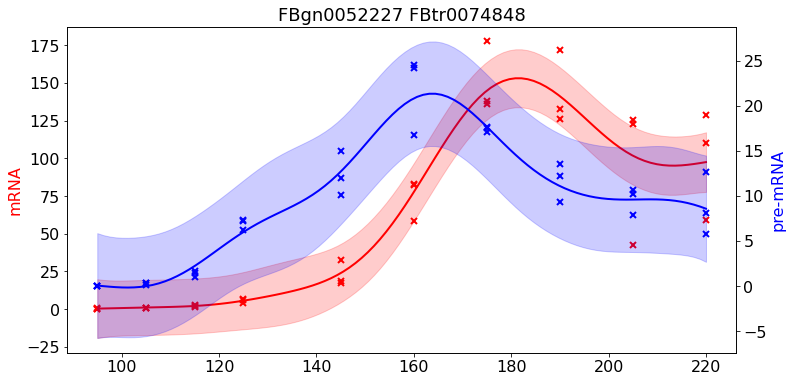

In [175]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations, variance_m, variance_p)

### Run MCMC

In [184]:
#parameters = list(dict_parameters.values())
#parameters

In [185]:
#parameters_vector = tf.stack(parameters)
#parameters_vector

In [181]:
# np.random.seed(100)
# tf.random.set_seed(100)
# from pathlib import Path
# #pathname = f"different gene results mala-{step_size}"
# parameters_vector = tf.stack(parameters)
# hmc_parameters = HMCParameters(num_samples=1000, num_burnin_steps=1000)
# hmc_helper, run_chain = create_mala_mcmc(trcd, parameters, hmc_parameters)
# gpflow.config.set_default_positive_minimum(1e-6)
# #print(step_size_mala)
# step_size_mala = np.array([ 10**-5 , 10**-4 , 10**-3 , 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 1])
# for j in range(step_size_mala.shape[0]):
#     step_size = step_size_mala[j]

#     try:
#         experiment_print(j, "Run MCMC")
#         #num_leapfrog, step_size = leapfrog_num_and_step_size[j]
#         pathname = f"different gene results mala-{step_size}"
#         experiment_print(j, f"Save results at '{pathname}'")

#         samples = run_mala(run_chain,
#                                hmc_helper,
#                                step_size=step_size_mala[j])
#         analyse_samples(gene_id, tr_id, step_size, parameters_vector, *samples, dict_parameters=dict_parameters, pathname=pathname)
#             #reset_parameters(parameters, initial_values)
#         experiment_print(j, f"MCMC finished")
#     except:
#         print('Experiment error')

In [179]:
pathname = f"different gene results mala-{0.05}"
df = pd.read_csv(f'{pathname}/hpd'+str(gene_id)+'_'+str(tr_id)+'0.05'+'.csv')

In [180]:
df

,Unnamed: 0,parameter,MAP,hpd_l,hpd_u
0,0,D,0.005335,0.000002,0.009881
1,1,variance,24.565751,23.243225,25.894587
2,2,lengthscale,15.544531,13.598129,17.629224
3,3,variance_m,40.525665,38.898004,42.183924
4,4,variance_p,3.600137,3.135913,4.104357


### half-life HPD

In [182]:
np.log(2)/np.asarray(0.0000)

inf

In [183]:
np.log(2)/np.asarray(0.009881)

70.14949707114111

## Original data

In [35]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data_orig, initial_lengthscale, initial_variance, initial_S, transform_base=None)
dict_parameters = select_parameters(dict_parameters,
                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=326.27737426423806
Step 10 loss=289.3153301641569
Step 20 loss=289.29130005524223


In [36]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   0.023169 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │            │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   0.362199 │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ TRCD.model.kernel.variance       │ Par

### half-life

In [37]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

29.917017371480387

predicted y failed, predicted f


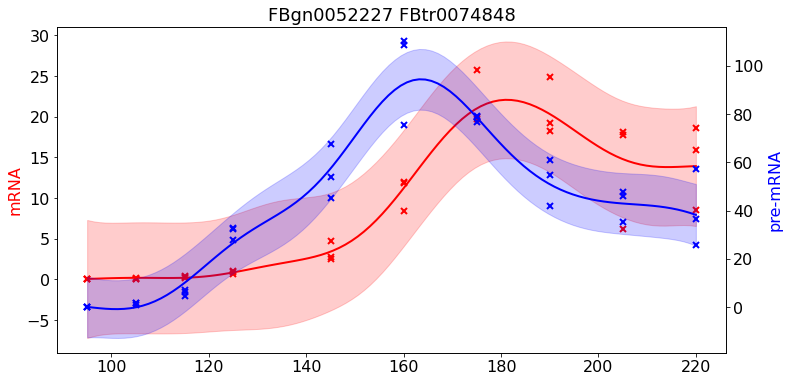

In [38]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations_orig, variance_m, variance_p)

### Run MCMC 

In [54]:
import pandas as pd

In [55]:
df = pd.read_csv('results_mala_processed/hpdFBgn0052227_FBtr0074848.csv')

In [56]:
df

,Unnamed: 0,Unnamed: 0.1,parameter,MAP,hpd_l,hpd_u
0,0,0,D,0.0234,0.0000,0.0524
1,1,1,S,0.3635,0.1895,0.6432
2,2,2,variance,110.8938,108.1771,113.6120
3,3,3,lengthscale,16.0670,14.3370,17.9985
4,4,4,variance_m,5.4732,4.7634,6.2805
5,5,5,variance_p,20.4251,18.9622,21.9362


In [187]:
np.log(2)/np.asarray(0.0)

inf

In [188]:
np.log(2)/np.asarray(0.0524)

13.22799962900659